### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
from models.nnUNet.nnunet import Nested_UNet as UNet_2p

random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/ISIC-2017/trainset/images/*')
train_labels = glob.glob('/data/segmentation/ISIC-2017/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/ISIC-2017/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/ISIC-2017/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외


train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)


custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))


custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

# train_images = sorted(train_images)
# train_labels = sorted(train_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)
        
# valid_images = sorted(valid_images)
# valid_labels = sorted(valid_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)

My custom training-dataset has 2000 elements
My custom valing-dataset has 150 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

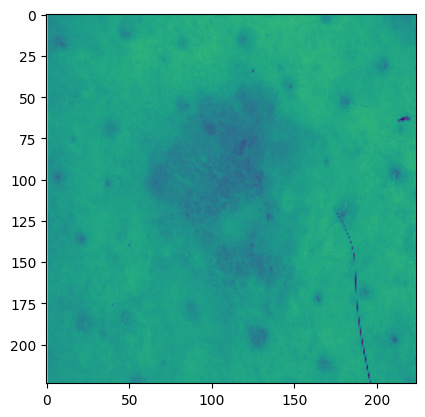

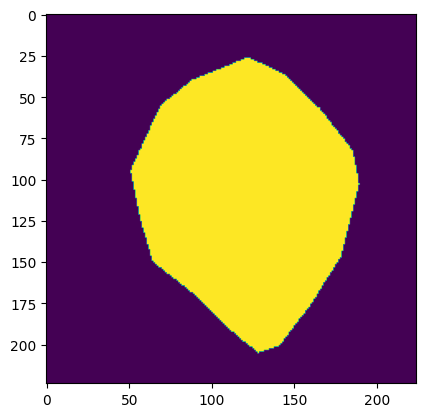

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [8]:
# Begin training
model = UNet_2p(1,3)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 50
patience = 10
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = IoULoss()
# model_name = 'UNet_IoULoss_baseline'

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCELoss_baseline'

criterion = DiceBCELoss()
model_name = 'UNet_2p_DiceBCELoss_baseline'


# 5. Training

In [11]:
def dice_pytorch_eval(outputs: torch.Tensor, labels: torch.Tensor):

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5

    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # (BATCH, 1, H, W) -> (BATCH, H, W)
    labels = labels.squeeze(1).byte()


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    dice = 2 * (intersection + SMOOTH) / (intersection + union + SMOOTH) # We smooth our devision to avoid 0/0

    return dice.mean()

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 0 of 50, Iter.: 250 of 250, Train Loss: 0.883176, IoU: 0.606772, Dice: 0.715705
 Epoch: 0 of 50, Iter.: 250 of 250, Valid Loss: 0.895313, IoU: 0.628291, Dice: 0.732870

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


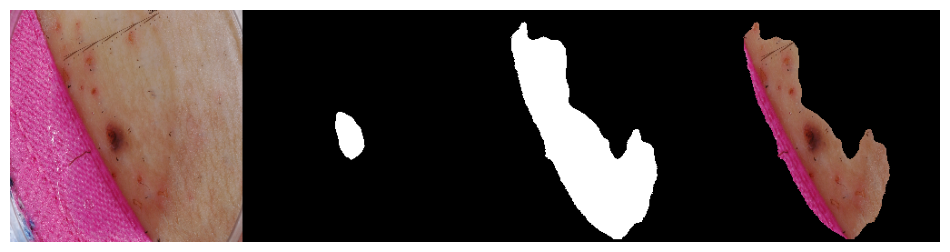

 Epoch: 1 of 50, Iter.: 250 of 250, Train Loss: 0.709055, IoU: 0.690199, Dice: 0.787505
 Epoch: 1 of 50, Iter.: 250 of 250, Valid Loss: 0.817884, IoU: 0.603652, Dice: 0.719022


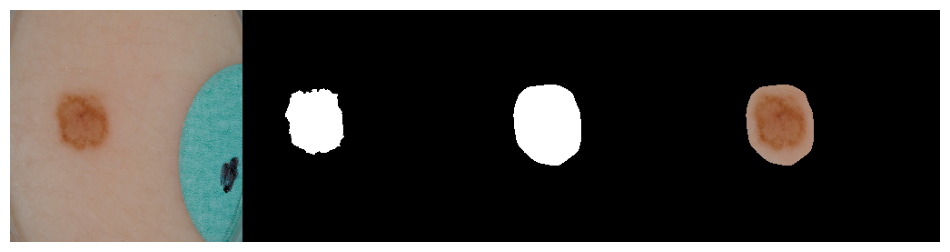

 Epoch: 2 of 50, Iter.: 250 of 250, Train Loss: 0.601647, IoU: 0.723906, Dice: 0.816262
 Epoch: 2 of 50, Iter.: 250 of 250, Valid Loss: 0.690857, IoU: 0.681064, Dice: 0.780891


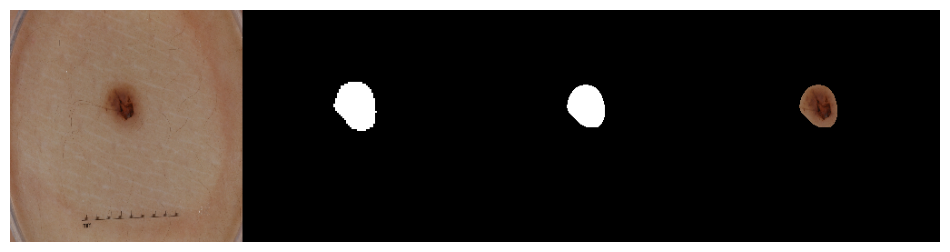

 Epoch: 3 of 50, Iter.: 250 of 250, Train Loss: 0.523407, IoU: 0.746065, Dice: 0.833114
 Epoch: 3 of 50, Iter.: 250 of 250, Valid Loss: 0.630261, IoU: 0.712102, Dice: 0.802415


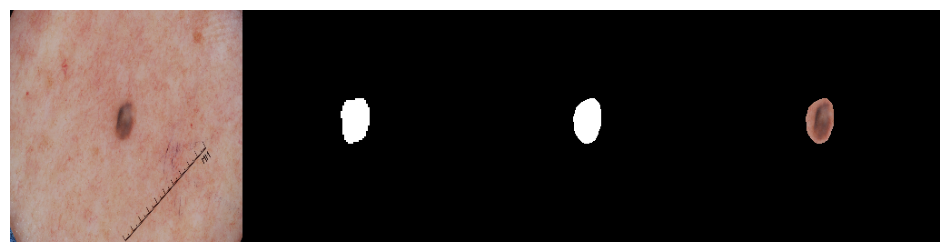

 Epoch: 4 of 50, Iter.: 250 of 250, Train Loss: 0.441814, IoU: 0.768251, Dice: 0.851159
 Epoch: 4 of 50, Iter.: 250 of 250, Valid Loss: 0.566476, IoU: 0.715514, Dice: 0.809430


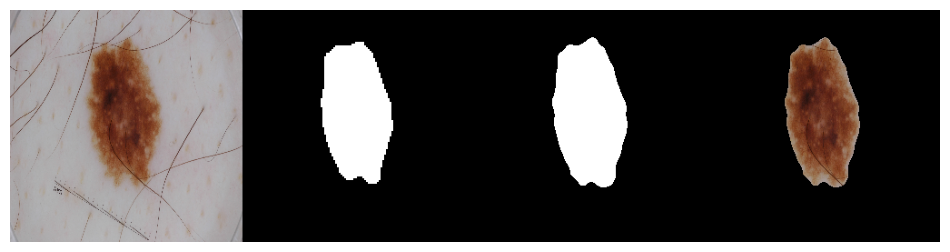

 Epoch: 5 of 50, Iter.: 250 of 250, Train Loss: 0.401613, IoU: 0.769303, Dice: 0.853253
 Epoch: 5 of 50, Iter.: 250 of 250, Valid Loss: 0.548566, IoU: 0.706724, Dice: 0.796105


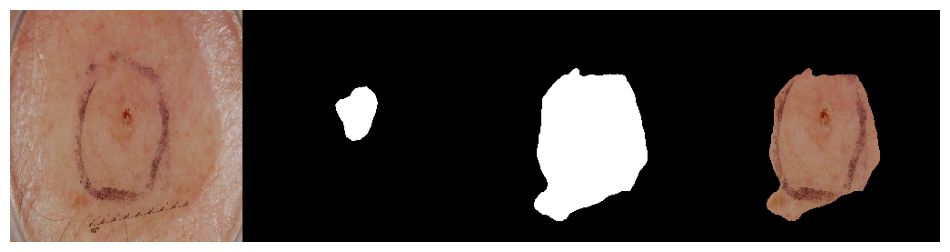

 Epoch: 6 of 50, Iter.: 250 of 250, Train Loss: 0.360678, IoU: 0.783182, Dice: 0.863086
 Epoch: 6 of 50, Iter.: 250 of 250, Valid Loss: 0.561463, IoU: 0.692726, Dice: 0.782316


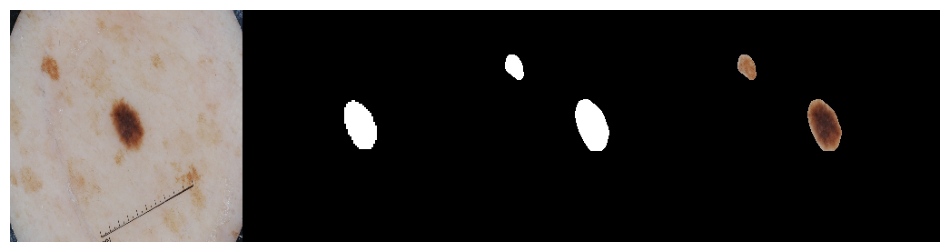

 Epoch: 7 of 50, Iter.: 250 of 250, Train Loss: 0.335886, IoU: 0.788249, Dice: 0.866768
 Epoch: 7 of 50, Iter.: 250 of 250, Valid Loss: 0.509555, IoU: 0.715709, Dice: 0.800532


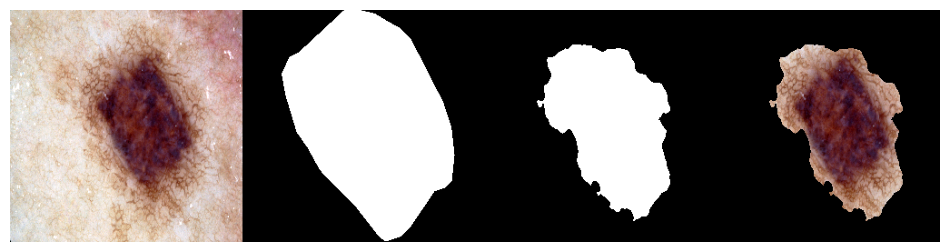

 Epoch: 8 of 50, Iter.: 250 of 250, Train Loss: 0.302609, IoU: 0.796171, Dice: 0.873413
 Epoch: 8 of 50, Iter.: 250 of 250, Valid Loss: 0.468087, IoU: 0.731449, Dice: 0.823597


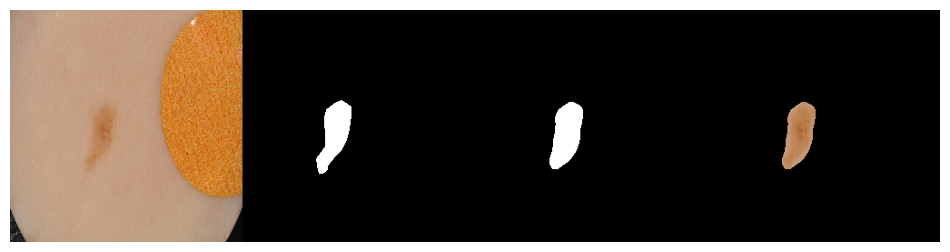

 Epoch: 9 of 50, Iter.: 250 of 250, Train Loss: 0.287483, IoU: 0.801770, Dice: 0.877359
 Epoch: 9 of 50, Iter.: 250 of 250, Valid Loss: 0.436824, IoU: 0.728558, Dice: 0.816640


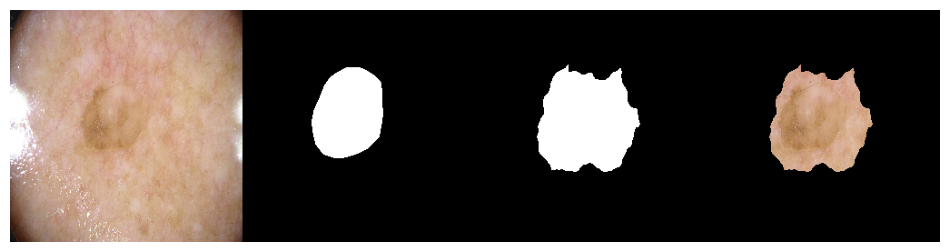

 Epoch: 10 of 50, Iter.: 250 of 250, Train Loss: 0.270498, IoU: 0.807454, Dice: 0.881792
 Epoch: 10 of 50, Iter.: 250 of 250, Valid Loss: 0.442879, IoU: 0.727079, Dice: 0.818756


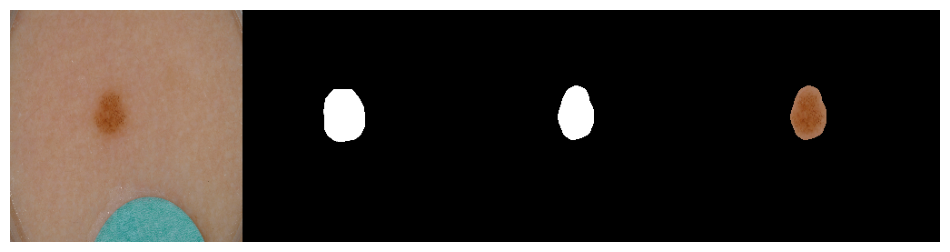

 Epoch: 11 of 50, Iter.: 250 of 250, Train Loss: 0.259682, IoU: 0.808316, Dice: 0.882979
 Epoch: 11 of 50, Iter.: 250 of 250, Valid Loss: 0.474921, IoU: 0.726697, Dice: 0.815102


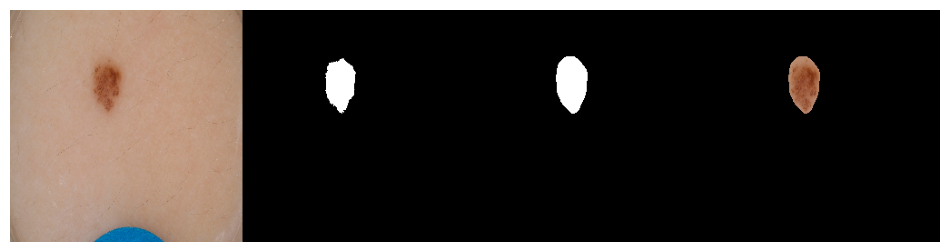

 Epoch: 12 of 50, Iter.: 250 of 250, Train Loss: 0.237015, IoU: 0.814267, Dice: 0.886612
 Epoch: 12 of 50, Iter.: 250 of 250, Valid Loss: 0.426613, IoU: 0.734169, Dice: 0.823194


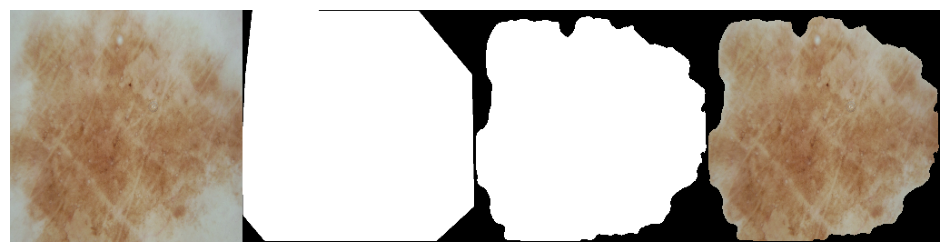

 Epoch: 13 of 50, Iter.: 250 of 250, Train Loss: 0.236938, IoU: 0.816017, Dice: 0.887936
 Epoch: 13 of 50, Iter.: 250 of 250, Valid Loss: 0.481971, IoU: 0.716401, Dice: 0.808174


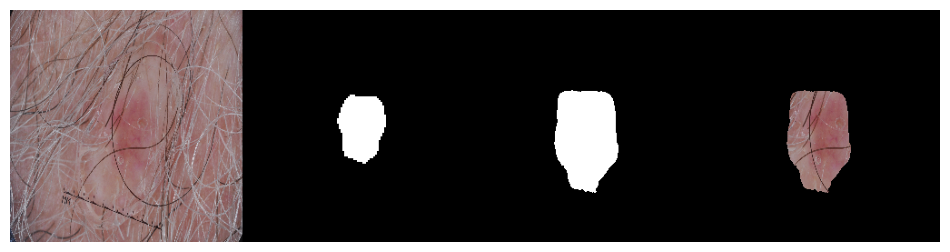

 Epoch: 14 of 50, Iter.: 250 of 250, Train Loss: 0.230166, IoU: 0.816711, Dice: 0.888573
 Epoch: 14 of 50, Iter.: 250 of 250, Valid Loss: 0.498301, IoU: 0.723781, Dice: 0.811339


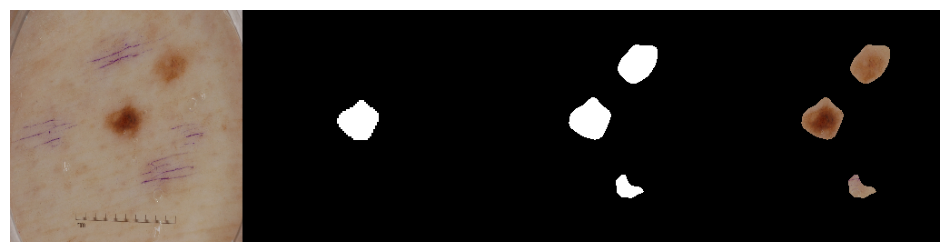

 Epoch: 15 of 50, Iter.: 250 of 250, Train Loss: 0.221330, IoU: 0.823826, Dice: 0.894203
 Epoch: 15 of 50, Iter.: 250 of 250, Valid Loss: 0.459066, IoU: 0.729592, Dice: 0.821477


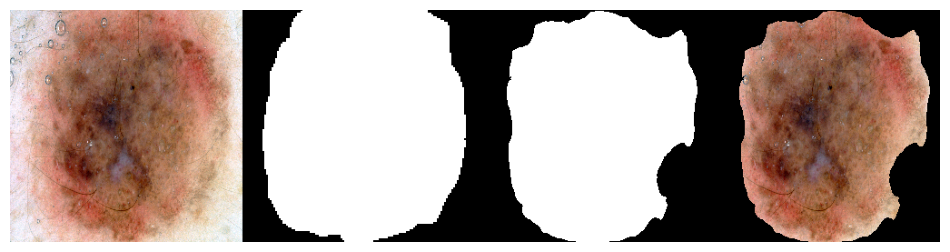

 Epoch: 16 of 50, Iter.: 250 of 250, Train Loss: 0.203434, IoU: 0.832710, Dice: 0.900962
 Epoch: 16 of 50, Iter.: 250 of 250, Valid Loss: 0.454672, IoU: 0.721663, Dice: 0.806216


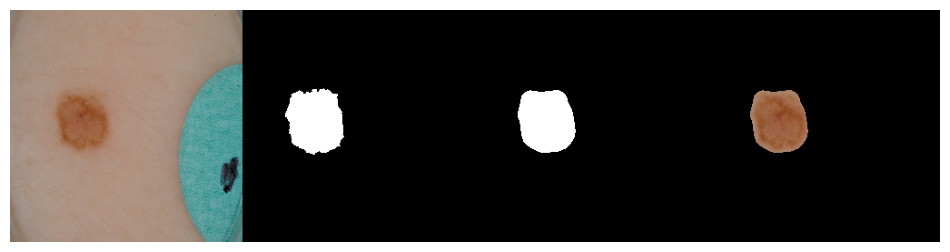

 Epoch: 17 of 50, Iter.: 250 of 250, Train Loss: 0.199461, IoU: 0.832713, Dice: 0.900930
 Epoch: 17 of 50, Iter.: 250 of 250, Valid Loss: 0.419980, IoU: 0.733544, Dice: 0.823424


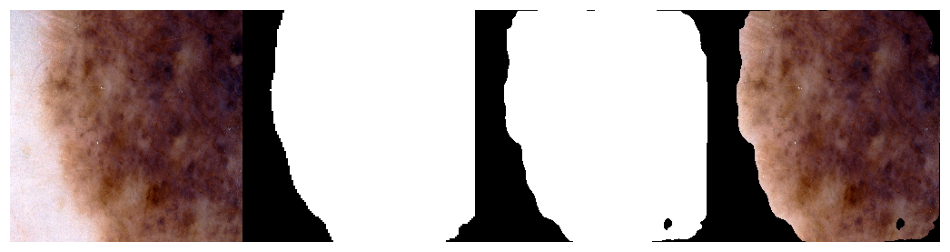

 Epoch: 18 of 50, Iter.: 250 of 250, Train Loss: 0.190613, IoU: 0.835989, Dice: 0.903648
 Epoch: 18 of 50, Iter.: 250 of 250, Valid Loss: 0.407454, IoU: 0.742195, Dice: 0.831246


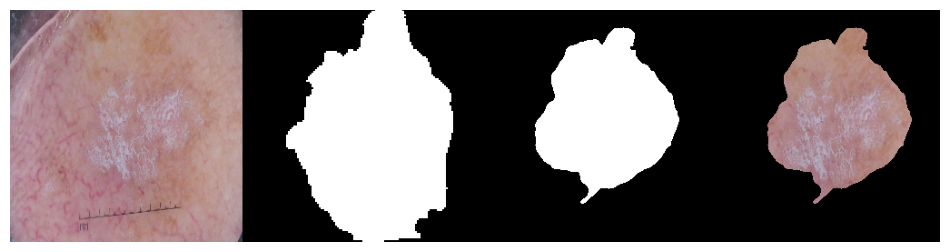

 Epoch: 19 of 50, Iter.: 250 of 250, Train Loss: 0.182676, IoU: 0.836771, Dice: 0.904260
 Epoch: 19 of 50, Iter.: 250 of 250, Valid Loss: 0.450417, IoU: 0.733083, Dice: 0.823782


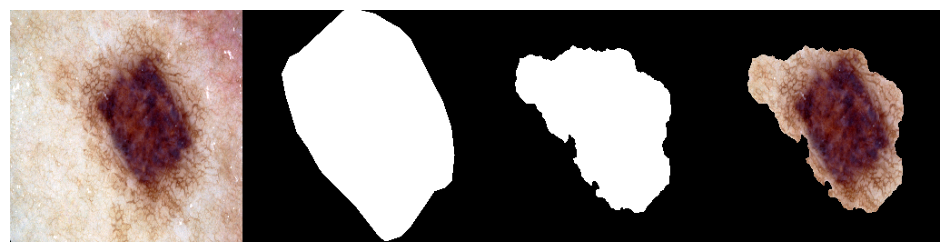

 Epoch: 20 of 50, Iter.: 250 of 250, Train Loss: 0.177158, IoU: 0.843808, Dice: 0.909629
 Epoch: 20 of 50, Iter.: 250 of 250, Valid Loss: 0.450792, IoU: 0.728443, Dice: 0.819895
 Epoch: 21 of 50, Iter.: 250 of 250, Train Loss: 0.179715, IoU: 0.840307, Dice: 0.906255
 Epoch: 21 of 50, Iter.: 250 of 250, Valid Loss: 0.544105, IoU: 0.705804, Dice: 0.799389


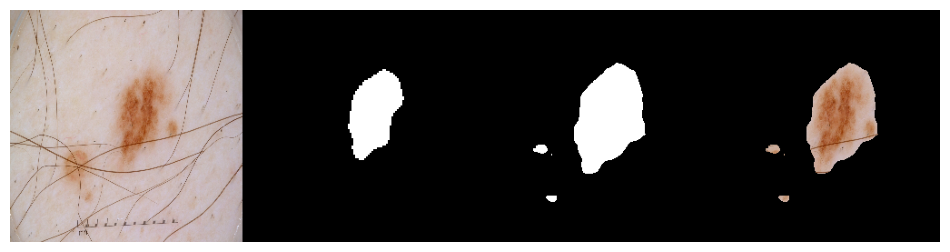

 Epoch: 22 of 50, Iter.: 250 of 250, Train Loss: 0.183766, IoU: 0.838182, Dice: 0.905171
 Epoch: 22 of 50, Iter.: 250 of 250, Valid Loss: 0.456016, IoU: 0.734550, Dice: 0.824213


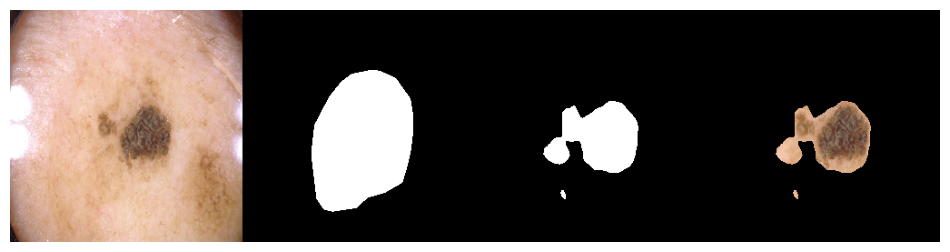

 Epoch: 23 of 50, Iter.: 250 of 250, Train Loss: 0.164855, IoU: 0.849023, Dice: 0.913090
 Epoch: 23 of 50, Iter.: 250 of 250, Valid Loss: 0.459630, IoU: 0.741886, Dice: 0.831525


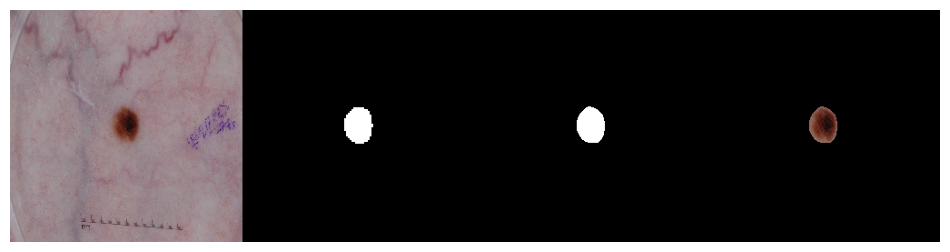

 Epoch: 24 of 50, Iter.: 250 of 250, Train Loss: 0.155597, IoU: 0.852829, Dice: 0.915563
 Epoch: 24 of 50, Iter.: 250 of 250, Valid Loss: 0.470490, IoU: 0.731642, Dice: 0.820908


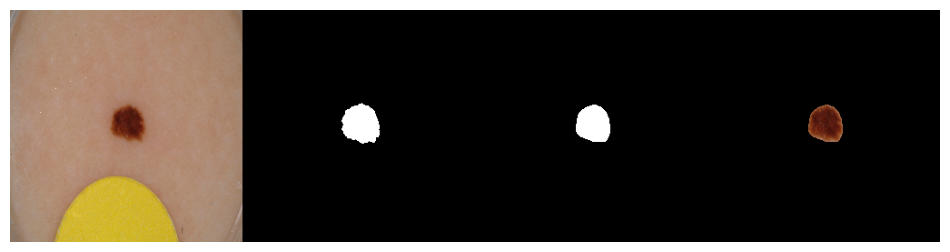

 Epoch: 25 of 50, Iter.: 250 of 250, Train Loss: 0.152231, IoU: 0.855882, Dice: 0.917706
 Epoch: 25 of 50, Iter.: 250 of 250, Valid Loss: 0.443657, IoU: 0.732905, Dice: 0.823411
 Epoch: 26 of 50, Iter.: 250 of 250, Train Loss: 0.155953, IoU: 0.853984, Dice: 0.916601
 Epoch: 26 of 50, Iter.: 250 of 250, Valid Loss: 0.476117, IoU: 0.733686, Dice: 0.824183


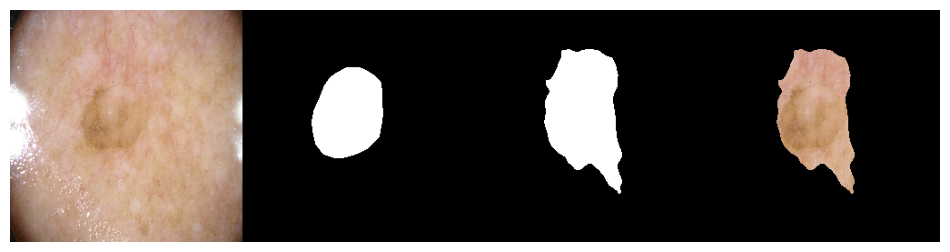

 Epoch: 27 of 50, Iter.: 250 of 250, Train Loss: 0.142502, IoU: 0.859868, Dice: 0.920425
 Epoch: 27 of 50, Iter.: 250 of 250, Valid Loss: 0.456302, IoU: 0.740429, Dice: 0.827653
 Epoch: 28 of 50, Iter.: 250 of 250, Train Loss: 0.136074, IoU: 0.864804, Dice: 0.924082
 Epoch: 28 of 50, Iter.: 250 of 250, Valid Loss: 0.413648, IoU: 0.744377, Dice: 0.833575


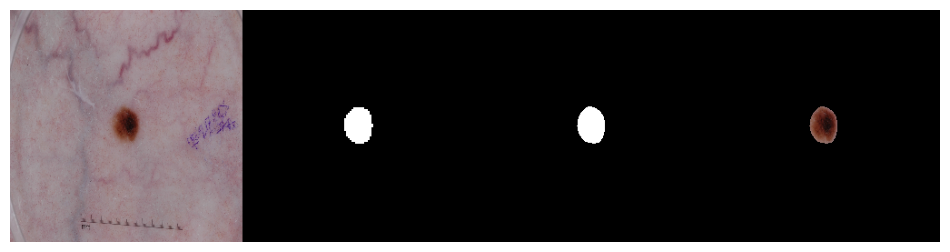

 Epoch: 29 of 50, Iter.: 250 of 250, Train Loss: 0.139822, IoU: 0.864269, Dice: 0.923345
 Epoch: 29 of 50, Iter.: 250 of 250, Valid Loss: 0.472209, IoU: 0.735885, Dice: 0.826671


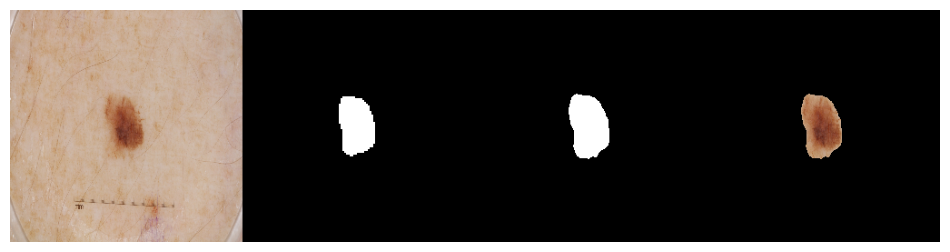

 Epoch: 30 of 50, Iter.: 250 of 250, Train Loss: 0.131569, IoU: 0.868498, Dice: 0.926197
 Epoch: 30 of 50, Iter.: 250 of 250, Valid Loss: 0.464772, IoU: 0.736052, Dice: 0.823887


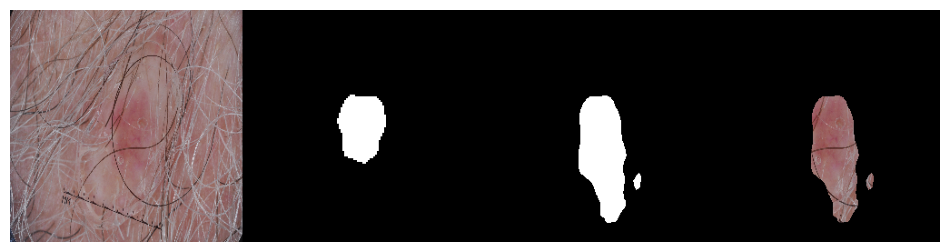

 Epoch: 31 of 50, Iter.: 250 of 250, Train Loss: 0.123148, IoU: 0.873085, Dice: 0.929073
 Epoch: 31 of 50, Iter.: 250 of 250, Valid Loss: 0.449865, IoU: 0.738213, Dice: 0.826774


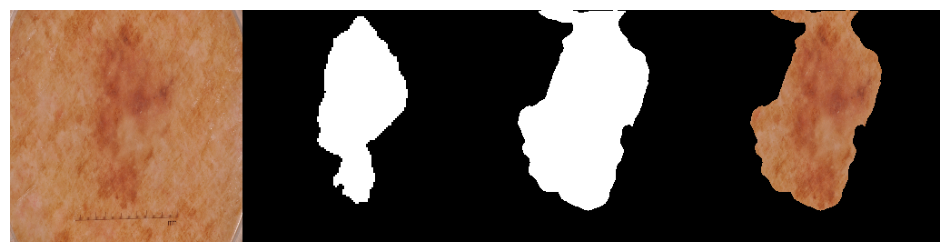

 Epoch: 32 of 50, Iter.: 250 of 250, Train Loss: 0.121114, IoU: 0.874588, Dice: 0.930512
 Epoch: 32 of 50, Iter.: 250 of 250, Valid Loss: 0.429524, IoU: 0.731137, Dice: 0.823078


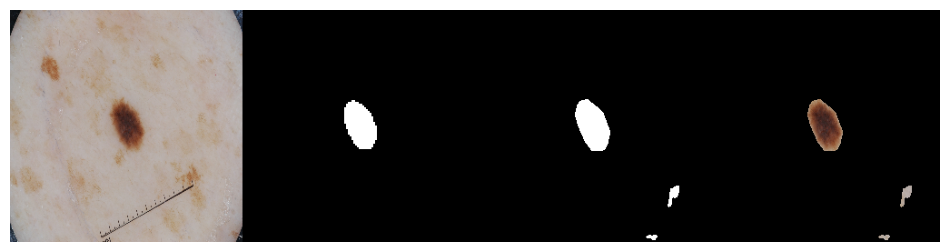

 Epoch: 33 of 50, Iter.: 250 of 250, Train Loss: 0.119378, IoU: 0.875933, Dice: 0.931448
 Epoch: 33 of 50, Iter.: 250 of 250, Valid Loss: 0.511707, IoU: 0.718218, Dice: 0.812482


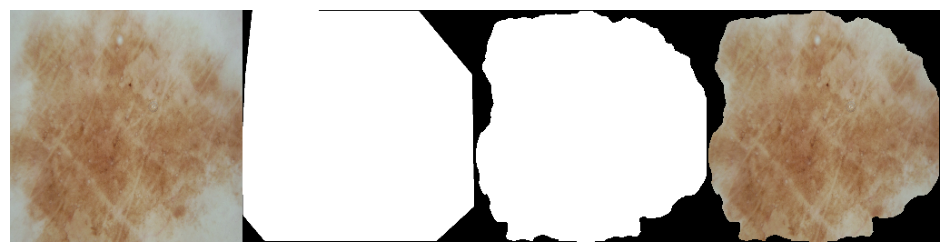

 Epoch: 34 of 50, Iter.: 250 of 250, Train Loss: 0.121339, IoU: 0.873051, Dice: 0.929125
 Epoch: 34 of 50, Iter.: 250 of 250, Valid Loss: 0.487788, IoU: 0.731546, Dice: 0.824221


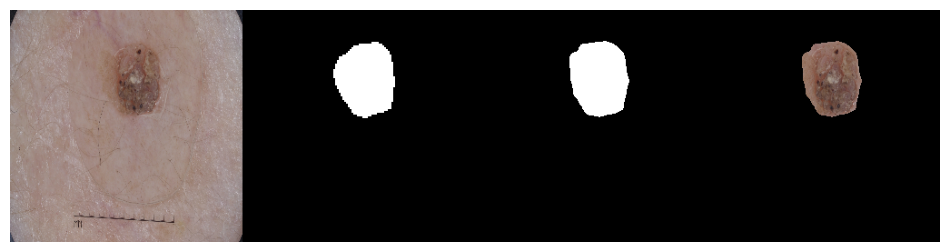

 Epoch: 35 of 50, Iter.: 250 of 250, Train Loss: 0.114399, IoU: 0.879980, Dice: 0.933894
 Epoch: 35 of 50, Iter.: 250 of 250, Valid Loss: 0.571394, IoU: 0.702657, Dice: 0.800582


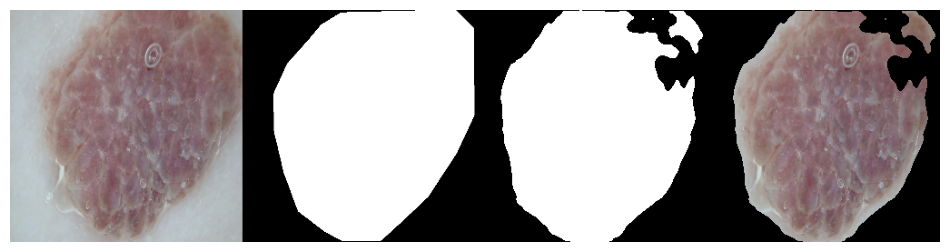

 Epoch: 36 of 50, Iter.: 250 of 250, Train Loss: 0.128461, IoU: 0.869760, Dice: 0.926917
 Epoch: 36 of 50, Iter.: 250 of 250, Valid Loss: 0.513510, IoU: 0.727407, Dice: 0.817296


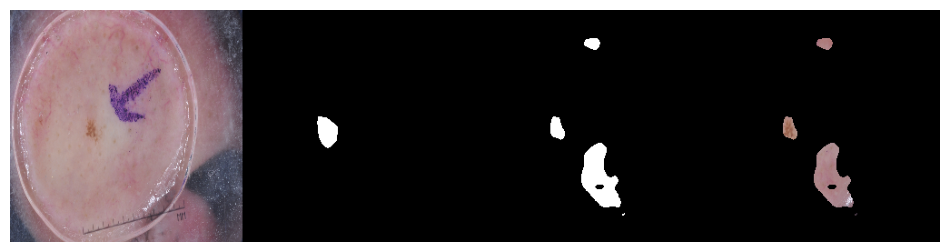

 Epoch: 37 of 50, Iter.: 250 of 250, Train Loss: 0.112441, IoU: 0.880700, Dice: 0.934028
 Epoch: 37 of 50, Iter.: 250 of 250, Valid Loss: 0.480020, IoU: 0.743076, Dice: 0.832361


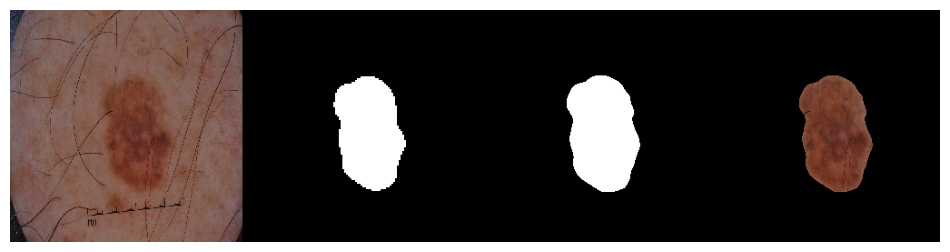

 Epoch: 38 of 50, Iter.: 250 of 250, Train Loss: 0.102900, IoU: 0.888669, Dice: 0.939306
 Epoch: 38 of 50, Iter.: 250 of 250, Valid Loss: 0.527762, IoU: 0.732400, Dice: 0.820737


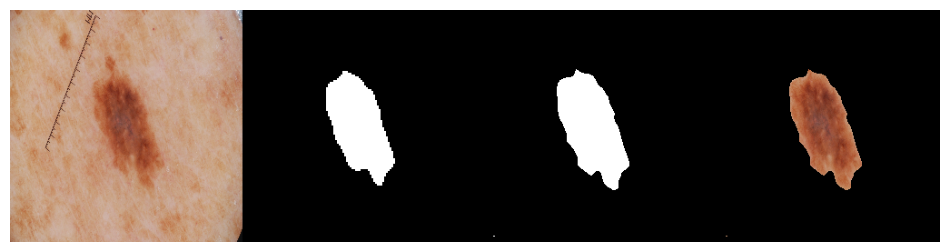

 Epoch: 39 of 50, Iter.: 250 of 250, Train Loss: 0.097904, IoU: 0.892203, Dice: 0.941323
 Epoch: 39 of 50, Iter.: 250 of 250, Valid Loss: 0.540942, IoU: 0.737165, Dice: 0.825125


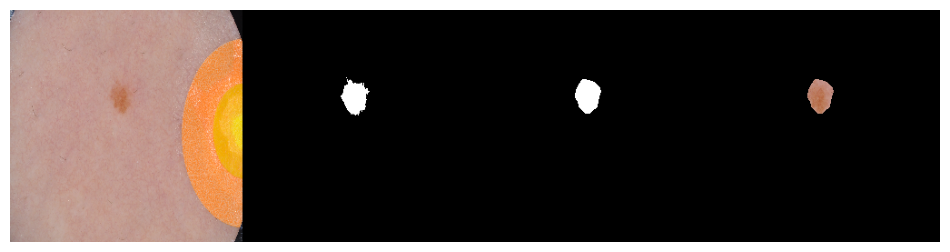


Early stopping. Target criteria has not improved for 10 epochs.

CPU times: user 15min 21s, sys: 12min 56s, total: 28min 18s
Wall time: 3h 7min 8s


In [12]:

%%time
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test
from ploting import plot_model_prediction

data_name = 'ISIC'

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch = -1
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

for epoch in range(epochs):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 0:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    if epoch+1 % 10 == 0:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
        for i, (metric, value) in enumerate(metrics.items()):
            axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=3)
            axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=3)
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel('Loss')
            axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
            axs[i].legend(loc='best')
        plt.show()
    
    lst_epoch_metric.append([round(epoch_train_loss,2), round(epoch_val_loss,2), round(epoch_train_iou,2), 
                             round(epoch_val_iou,2), round(epoch_train_dice,2), round(epoch_val_dice,2)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_iou = epoch if best_iou == epoch_val_iou else best_epoch_iou
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

# load once more and write all the losses down (othw can miss the last 10)
state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'metric_{model_name}_{data_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_IOU:0.7444, Best_DiceScore:0.8336


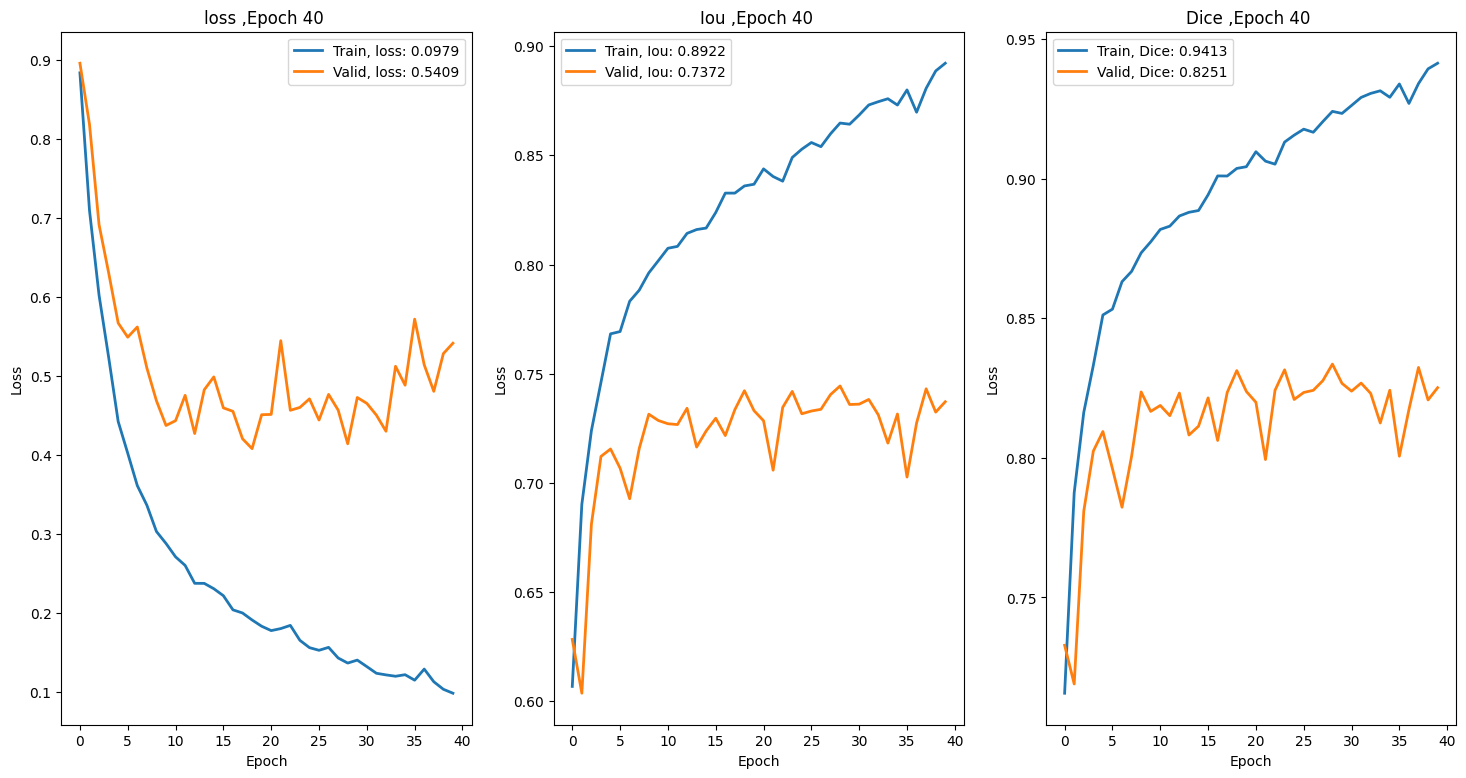

In [13]:
print(f'Validationset 기준 \nBest_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

# metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
#            'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
#            'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
    axs[i].legend(loc='best')
plt.show()